# **Homework 2**

## **2.1 Loading the MNIST dataset**

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [ ]:
( train_ds , test_ds ) , ds_info = tfds.load('mnist', split =[ 'train', 'test'], as_supervised = True , with_info = True )
print(ds_info)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1.incomplete5FFY2C',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      

**How many training/test images are there?**
* 10000 test and 60000 train images  

**What’s the image shape?**  
* (28,28,1)

**What range are pixel values in?**
* 0-255

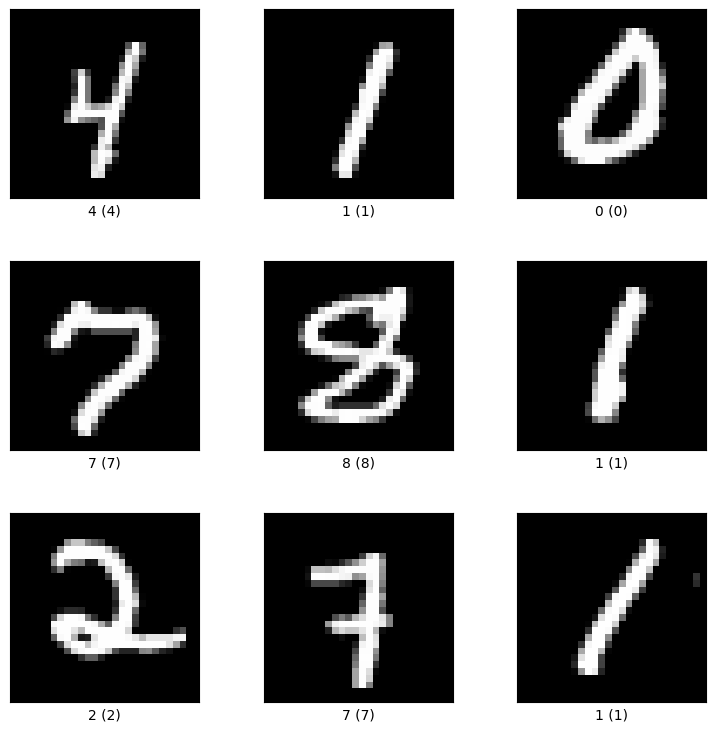

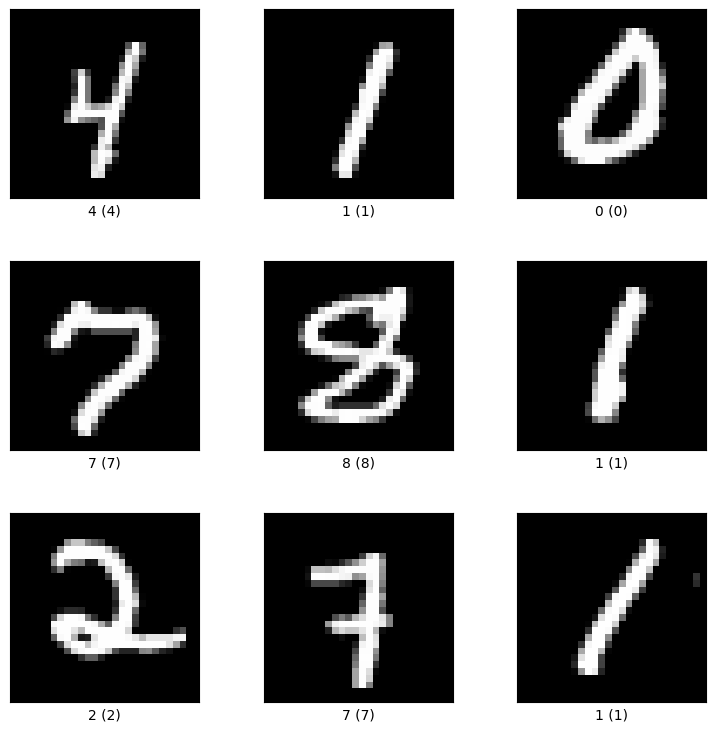

In [ ]:
tfds.show_examples(train_ds , ds_info)

## **2.2 Setting up the data pipeline**

In [ ]:
def data_prep(data):
  batch_size = 32
  shuffle_size = 1000
  prefetch_size = 20
  # take a dictionary and pass image and label on
  #data = data.map(lambda feature_dict: (feature_dict['image'], feature_dict['label']))
  # reshape images
  data = data.map(lambda image, label: (tf.reshape(image, (-1,)), label))
  # scale down respective pixels to range 127 & cast to float
  data = data.map(lambda image, label: ((tf.cast(image, tf.float32)/128)-1, label))
  # one hotify the labels
  data = data.map(lambda image, label: (image, tf.one_hot(label, depth=10)))
  # shuffle data and then batch of the suffled data
  data = data.shuffle(shuffle_size).batch(batch_size)
  # prefetch function, makes sure prefetch_size batches are always ready
  data = data.prefetch(prefetch_size)

  return data

## **2.3 Building a deep neural network with TensorFlow**

In [ ]:
class MNIST_Model(tf.keras.Model):

  def __init__(self, layer_sizes, output_size=10):
    super().__init__()
    self.mlp_layers = []
    # create layers
    for layer_size in layer_sizes:
        new_layer = tf.keras.layers.Dense(units=layer_size, activation='relu')
        self.mlp_layers.append(new_layer)
    # output layer
    self.output_layer = tf.keras.layers.Dense(units=output_size, activation='softmax')


  def call(self, x):
    for layer in self.mlp_layers:
      x = layer(x)
    y = self.output_layer(x)
    return y

## **2.4 Training the network**

In [ ]:
def train_loop(model, train_ds, test_ds, loss_func, optimizer, num_epochs=10):

  train_losses = []
  train_accuracies = []
  test_losses = []
  test_accuracies = []

  # one epoch: training the network once with the whole dataset
  for epoch in range(num_epochs):

    #training
    epoch_losses = []
    epoch_accuracies = []
    for input,target in train_ds:
        loss, accuracy = train_step(model, input, target, loss_func, optimizer)
        epoch_losses.append(loss)
        epoch_accuracies.append(accuracy)

    #track training loss and accuracies
    train_losses.append(tf.reduce_mean(epoch_losses))
    train_accuracies.append(tf.reduce_mean(epoch_accuracies))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test_loop(model, test_ds, loss_func)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f' After epoch {str(epoch)} the accuracy is: {test_accuracies[-1]}')
    print(f' After epoch {str(epoch)} the loss is: {test_losses[-1]}')

  return train_losses, train_accuracies, test_losses, test_accuracies

def train_step(model, input, target, loss_function, optimizer):

  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    accuracy = np.mean(accuracy)

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return loss, accuracy

def test_loop(model, test_ds, loss_func):
  test_accuracy_agg = []
  test_loss_agg = []

  for (input, target) in test_ds:
    prediction = model(input)
    sample_test_loss = loss_func(target, prediction)
    # sample_test_accuracy hat boolean pro sample in batch (länge ist also wie batch size)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    # mean accuracy for the batch
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_agg.append(sample_test_loss.numpy())
    test_accuracy_agg.append(sample_test_accuracy)


  test_loss = tf.reduce_mean(test_loss_agg)
  test_accuracy = tf.reduce_mean(test_accuracy_agg)

  return test_loss, test_accuracy


In [ ]:
# main
train_ds, test_ds = tfds.load('mnist', split =[ 'train', 'test'], as_supervised = True)

# data
train_data = train_ds.apply(data_prep)
test_data = test_ds.apply(data_prep)



In [ ]:
# model
layer_sizes = [256,256]
mnistModel = MNIST_Model(layer_sizes)

# training
loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.001
optimizer = tf.keras.optimizers.SGD(learning_rate)
num_epochs = 3
train_losses, train_accuracies, test_losses, test_accuracies = train_loop(mnistModel, train_data, test_data, loss_func, optimizer, num_epochs)

 After epoch 0 the accuracy is: 0.8588258785942492
 After epoch 0 the loss is: 0.5692025423049927
 After epoch 1 the accuracy is: 0.8884784345047924
 After epoch 1 the loss is: 0.41024747490882874
 After epoch 2 the accuracy is: 0.8990615015974441
 After epoch 2 the loss is: 0.35550010204315186


## **2.5 Visualization**

x-Achse: epochs können nur diskret sein

In [ ]:
def visualization( train_losses , train_accuracies , test_losses , test_accuracies):

  # Plot the Loss
  plt.plot(train_losses, color="red", label="Train")
  print(train_losses)
  plt.plot(test_losses, color="blue", label="Test")
  print(test_losses)
  plt.title("Train vs. Test Loss")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  # Plot the Accuracy
  plt.plot(train_accuracies, color="red", label="Train")
  plt.plot(test_accuracies, color="blue", label="Test")
  plt.title("Train vs. Test Accuracy")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.show()

[<tf.Tensor: shape=(), dtype=float32, numpy=1.0844283>, <tf.Tensor: shape=(), dtype=float32, numpy=0.49373952>, <tf.Tensor: shape=(), dtype=float32, numpy=0.39907>]
[<tf.Tensor: shape=(), dtype=float32, numpy=0.56920254>, <tf.Tensor: shape=(), dtype=float32, numpy=0.41024747>, <tf.Tensor: shape=(), dtype=float32, numpy=0.3555001>]


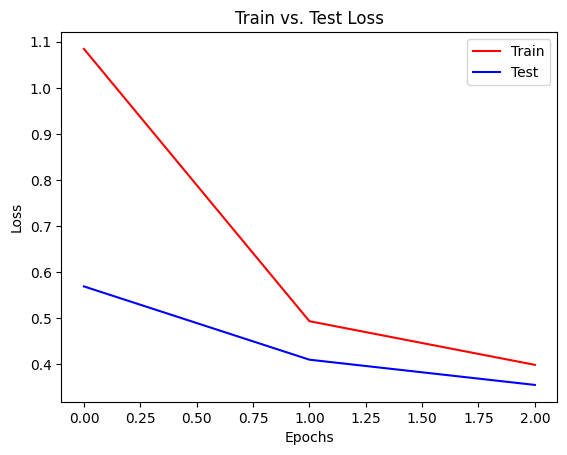

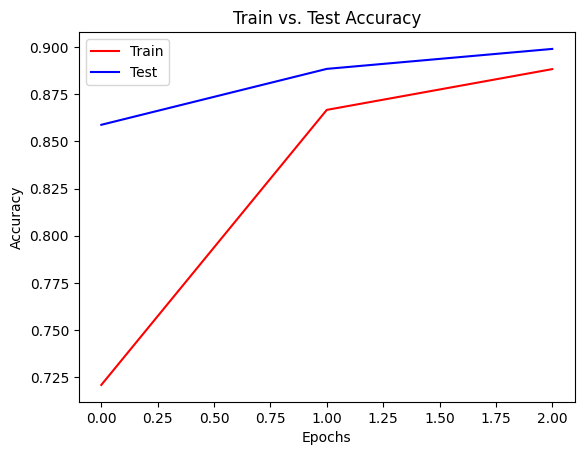

In [ ]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

# **3. Hyperparameter adjustment**

Adjust hyperparameter in order to evaluate the models performance, main parameter:
- learning rate
- batch size
- number of layers and size of layers in the model
- optimizer (so when using the SGD optimizer: momentum as hyperparameter)

-> 4 deviations from initial setup with interpretation

## **3.1 initial setup**

**data preparing parameter:**  
- batch size: 32

**model parameter:**  
- number of layers: 2  
- size of the layers: [256,256]

**training parameter:**  
- learning_rate = 0.001  
- optimizer: SGD  
- momentum = 0 (default momentum -> no momentum impact)  
- (num_epochs = 3)  
  
  
**training/testing the model:**  
train_losses, train_accuracies, test_losses, test_accuracies = train_loop(mnistModel, train_data, test_data, loss_func, optimizer, num_epochs)

## **3.2 learning rate adjustments**

In [ ]:
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5]

In [ ]:
# model
layer_sizes = [256,256] # same
mnistModel = MNIST_Model(layer_sizes)

# training
loss_func = tf.keras.losses.CategoricalCrossentropy()
#learning_rate = 0.001
num_epochs = 3

train_losses_list = []
train_accuracies_list = []
test_losses_list = []
test_accuracies_list = []


for rate in learning_rates:
  print("learning rate: ", str(rate))
  optimizer = tf.keras.optimizers.SGD(rate)
  train_losses, train_accuracies, test_losses, test_accuracies = train_loop(mnistModel, train_data, test_data, loss_func, optimizer, num_epochs)
  train_losses_list.append(train_losses)
  train_accuracies_list.append(train_accuracies)
  test_losses_list.append(test_losses)
  test_accuracies_list.append(test_accuracies)

learning rate:  0.001
 After epoch 0 the accuracy is: 0.8628194888178914
 After epoch 0 the loss is: 0.5587930083274841
 After epoch 1 the accuracy is: 0.8891773162939297
 After epoch 1 the loss is: 0.41096314787864685
 After epoch 2 the accuracy is: 0.9026557507987221
 After epoch 2 the loss is: 0.356971800327301
learning rate:  0.005
 After epoch 0 the accuracy is: 0.9214257188498403
 After epoch 0 the loss is: 0.274149090051651
 After epoch 1 the accuracy is: 0.9265175718849841
 After epoch 1 the loss is: 0.24989406764507294
 After epoch 2 the accuracy is: 0.9416932907348243
 After epoch 2 the loss is: 0.2070980668067932
learning rate:  0.01
 After epoch 0 the accuracy is: 0.9440894568690096
 After epoch 0 the loss is: 0.19082917273044586
 After epoch 1 the accuracy is: 0.9528753993610224
 After epoch 1 the loss is: 0.15605111420154572
 After epoch 2 the accuracy is: 0.9623602236421726
 After epoch 2 the loss is: 0.12577667832374573
learning rate:  0.05
 After epoch 0 the accuracy i

Evalutation of learning rate adjustments:
- lower learning rate: slower learning but lower risk of overfitting
- higher learning rate: faster good predictions but higher risk of overfitting/local maxima
- caution: if too high: weights get adjusted out of bounds which causes predictions either 0 or 1 (or close to them) so the network becomes to confident, so regardsless of input output will be a one-hot vector -> so prob for guessing right is 1:10 which explains the accuracy from about 10% (loss not available bc of log(0))
- it seems reasonable to use a litte bit higher öearning rate than with inital parameter settings

In [ ]:
batch_sizes = [1,8,16,32,64,256]

In [ ]:
def data_prep2(data):
  batch_size = 16
  shuffle_size = 1000
  prefetch_size = 20
  # take a dictionary and pass image and label on
  #data = data.map(lambda feature_dict: (feature_dict['image'], feature_dict['label']))
  # reshape images
  data = data.map(lambda image, label: (tf.reshape(image, (-1,)), label))
  # scale down respective pixels to range 127 & cast to float
  data = data.map(lambda image, label: ((tf.cast(image, tf.float32)/128)-1, label))
  # one hotify the labels
  data = data.map(lambda image, label: (image, tf.one_hot(label, depth=10)))
  # shuffle data and then batch of the suffled data
  data = data.shuffle(shuffle_size).batch(batch_size)
  # prefetch function, makes sure prefetch_size batches are always ready
  data = data.prefetch(prefetch_size)

  return data

In [ ]:
def trainModel(train_data, test_data):
  # model
  layer_sizes = [256,256]
  mnistModel = MNIST_Model(layer_sizes)

  # training
  loss_func = tf.keras.losses.CategoricalCrossentropy()
  learning_rate = 0.001
  optimizer = tf.keras.optimizers.SGD(learning_rate)
  num_epochs = 3
  train_losses, train_accuracies, test_losses, test_accuracies = train_loop(mnistModel, train_data, test_data, loss_func, optimizer, num_epochs)

In [ ]:
# data
print("batch size: 1")
train_data = train_ds.apply(data_prep2)
test_data = test_ds.apply(data_prep2)
trainModel(train_data, test_data)
# manually terminated after epoch 0 (~ 20 min)
# accuracy: 0.9476
# loss: 0.1840

batch size: 1
 After epoch 0 the accuracy is: 0.9476
 After epoch 0 the loss is: 0.18401366472244263


KeyboardInterrupt: ignored

In [ ]:
# data
print("batch size: 8")
train_data = train_ds.apply(data_prep2)
test_data = test_ds.apply(data_prep2)
trainModel(train_data, test_data)
# about 7 min training

batch size: 8
 After epoch 0 the accuracy is: 0.9099
 After epoch 0 the loss is: 0.33007562160491943
 After epoch 1 the accuracy is: 0.9233
 After epoch 1 the loss is: 0.27230748534202576
 After epoch 2 the accuracy is: 0.93
 After epoch 2 the loss is: 0.24573242664337158


In [ ]:
# data
print("batch size: 16")
train_data = train_ds.apply(data_prep2)
test_data = test_ds.apply(data_prep2)
trainModel(train_data, test_data)
# about 4 min training

batch size: 16
 After epoch 0 the accuracy is: 0.8906
 After epoch 0 the loss is: 0.4016641676425934
 After epoch 1 the accuracy is: 0.9104
 After epoch 1 the loss is: 0.3214350938796997
 After epoch 2 the accuracy is: 0.9177
 After epoch 2 the loss is: 0.287891685962677


In [ ]:
# data
print("batch size: 32")
train_data = train_ds.apply(data_prep2)
test_data = test_ds.apply(data_prep2)
trainModel(train_data, test_data)
# about 2 min training

batch size: 32
 After epoch 0 the accuracy is: 0.8734025559105432
 After epoch 0 the loss is: 0.520825982093811
 After epoch 1 the accuracy is: 0.8943690095846646
 After epoch 1 the loss is: 0.389474093914032
 After epoch 2 the accuracy is: 0.9052515974440895
 After epoch 2 the loss is: 0.34082546830177307


In [ ]:
# data
print("batch size: 64")
train_data = train_ds.apply(data_prep2)
test_data = test_ds.apply(data_prep2)
trainModel(train_data, test_data)
# 1 min training

batch size: 64
 After epoch 0 the accuracy is: 0.8121019108280255
 After epoch 0 the loss is: 0.7942795753479004
 After epoch 1 the accuracy is: 0.86046974522293
 After epoch 1 the loss is: 0.5364828109741211
 After epoch 2 the accuracy is: 0.8780851910828026
 After epoch 2 the loss is: 0.44486111402511597


In [ ]:
# data
print("batch size: 256")
train_data = train_ds.apply(data_prep2)
test_data = test_ds.apply(data_prep2)
trainModel(train_data, test_data)
# about 30 s training

batch size: 256
 After epoch 0 the accuracy is: 0.54169921875
 After epoch 0 the loss is: 1.74765145778656
 After epoch 1 the accuracy is: 0.716015625
 After epoch 1 the loss is: 1.292095422744751
 After epoch 2 the accuracy is: 0.77724609375
 After epoch 2 the loss is: 1.0111932754516602


**Evalutation of adjusting the batch size:**

- the smaller the batch size the longer it takes for the model to train since the gradients have to be calculated and updated for a bigger number of batches because there are less samples in the batch
- on the other hand the accuracy is higher with a smaller batch size because each sample gets more effect on the weights but caution, this can also lead to overfitting
- in the given case a batch size of 16 seems reasonable

## **3.3 network size adjustments**
1. number of layers
2. and number of units in one layer

### 3.3.1 adjusting number of layers

In [ ]:
nb_layers = [2,5,8,10,20]

In [ ]:
# model
#layer_sizes = [256,256]
layer_sizes = [256]

# training
loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.001
num_epochs = 3

train_losses_list = []
train_accuracies_list = []
test_losses_list = []
test_accuracies_list = []

for nb_l in nb_layers:
  mnistModel = MNIST_Model(layer_sizes*nb_l)
  print("number of layers: ", str(nb_l))
  optimizer = tf.keras.optimizers.SGD(learning_rate)
  train_losses, train_accuracies, test_losses, test_accuracies = train_loop(mnistModel, train_data, test_data, loss_func, optimizer, num_epochs)
  train_losses_list.append(train_losses)
  train_accuracies_list.append(train_accuracies)
  test_losses_list.append(test_losses)
  test_accuracies_list.append(test_accuracies)

number of layers:  2
 After epoch 0 the accuracy is: 0.8545327476038339
 After epoch 0 the loss is: 0.56718510389328
 After epoch 1 the accuracy is: 0.8835862619808307
 After epoch 1 the loss is: 0.41693925857543945
 After epoch 2 the accuracy is: 0.8958666134185304
 After epoch 2 the loss is: 0.3585814833641052
number of layers:  5
 After epoch 0 the accuracy is: 0.8236821086261981
 After epoch 0 the loss is: 0.6539655923843384
 After epoch 1 the accuracy is: 0.8882787539936102
 After epoch 1 the loss is: 0.39433613419532776
 After epoch 2 the accuracy is: 0.9045527156549521
 After epoch 2 the loss is: 0.3226287066936493
number of layers:  8
 After epoch 0 the accuracy is: 0.5709864217252396
 After epoch 0 the loss is: 1.5343924760818481
 After epoch 1 the accuracy is: 0.8376597444089456
 After epoch 1 the loss is: 0.5282002687454224
 After epoch 2 the accuracy is: 0.8827875399361023
 After epoch 2 the loss is: 0.38426846265792847
number of layers:  10
 After epoch 0 the accuracy is: 

**Evalutation of adjusting the number of layers in the model:**

- the more layer the longer takes the training since more parameters need to be updated
- too many hidden layers can lead to overfitting since the model learns the training data to well and misses to generalize to new examples
- so number of layers depends on complexity of the problem
- in given case it seems like the best number of layers is around 5

### 3.3.2 adjusting number of units in layer

In [ ]:
nb_units = [50,150,256,350]

In [ ]:
nb_layers = 2
layer_sizes = [nb_units[3]] * nb_layers
layer_sizes

[350, 350]

In [ ]:
# model
# layer_sizes = [256,256]
nb_layers = 2

# training
loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.001
num_epochs = 3

train_losses_list = []
train_accuracies_list = []
test_losses_list = []
test_accuracies_list = []

for nb_u in nb_units:
  layer_sizes = [nb_u] * nb_layers
  mnistModel = MNIST_Model(layer_sizes)
  print("number of units in the layers: ", str(nb_u))
  optimizer = tf.keras.optimizers.SGD(learning_rate)
  train_losses, train_accuracies, test_losses, test_accuracies = train_loop(mnistModel, train_data, test_data, loss_func, optimizer, num_epochs)
  train_losses_list.append(train_losses)
  train_accuracies_list.append(train_accuracies)
  test_losses_list.append(test_losses)
  test_accuracies_list.append(test_accuracies)

number of units in the layers:  50
 After epoch 0 the accuracy is: 0.7887380191693291
 After epoch 0 the loss is: 0.808424711227417
 After epoch 1 the accuracy is: 0.863917731629393
 After epoch 1 the loss is: 0.5013448596000671
 After epoch 2 the accuracy is: 0.8848841853035144
 After epoch 2 the loss is: 0.4128012955188751
number of units in the layers:  150
 After epoch 0 the accuracy is: 0.8491413738019169
 After epoch 0 the loss is: 0.610456109046936
 After epoch 1 the accuracy is: 0.8822883386581469
 After epoch 1 the loss is: 0.4290493130683899
 After epoch 2 the accuracy is: 0.8955670926517572
 After epoch 2 the loss is: 0.3683167099952698
number of units in the layers:  256
 After epoch 0 the accuracy is: 0.8616214057507987
 After epoch 0 the loss is: 0.5517614483833313
 After epoch 1 the accuracy is: 0.8912739616613419
 After epoch 1 the loss is: 0.40477558970451355
 After epoch 2 the accuracy is: 0.8997603833865815
 After epoch 2 the loss is: 0.3551986813545227
number of uni

**Evalutation of adjusting the number of units in one layer:**

- it holds the same as for number of layers in the model
- it seems like in given case the accuracy does not improve much with change from 256 to 350 units in the layers so probably the best performance can be achieved with about 256 units

## **3.4 optimizer adjustments**
- momentum


In [ ]:
momentums = [0., 0.005, 0.01, 0.05, 0.1, 0.2]

In [ ]:
# model
layer_sizes = [256,256] # same
mnistModel = MNIST_Model(layer_sizes)

# training
loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.001
num_epochs = 3

train_losses_list = []
train_accuracies_list = []
test_losses_list = []
test_accuracies_list = []


for momentum in momentums:
  print("momentum: ", str(momentum))
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
  train_losses, train_accuracies, test_losses, test_accuracies = train_loop(mnistModel, train_data, test_data, loss_func, optimizer, num_epochs)
  train_losses_list.append(train_losses)
  train_accuracies_list.append(train_accuracies)
  test_losses_list.append(test_losses)
  test_accuracies_list.append(test_accuracies)

momentum:  0.0
 After epoch 0 the accuracy is: 0.8605231629392971
 After epoch 0 the loss is: 0.5543661713600159
 After epoch 1 the accuracy is: 0.8890774760383386
 After epoch 1 the loss is: 0.40526095032691956
 After epoch 2 the accuracy is: 0.9003594249201278
 After epoch 2 the loss is: 0.35442668199539185
momentum:  0.005
 After epoch 0 the accuracy is: 0.9077476038338658
 After epoch 0 the loss is: 0.32568326592445374
 After epoch 1 the accuracy is: 0.9107428115015974
 After epoch 1 the loss is: 0.3084544837474823
 After epoch 2 the accuracy is: 0.9160343450479234
 After epoch 2 the loss is: 0.29243791103363037
momentum:  0.01
 After epoch 0 the accuracy is: 0.9202276357827476
 After epoch 0 the loss is: 0.2813723385334015
 After epoch 1 the accuracy is: 0.9231230031948882
 After epoch 1 the loss is: 0.27134382724761963
 After epoch 2 the accuracy is: 0.9261182108626198
 After epoch 2 the loss is: 0.2623002827167511
momentum:  0.05
 After epoch 0 the accuracy is: 0.927416134185303

**Evalutation of adjusting the momentum of the optimizer SGD:**

smaller momentum: smaller accuracy -> it takes longer to achieve same accuracy as with higher momentum
higher momentum: higher accuracy  

the higher the momentum the fast a higher accuracy is achieved -> using a bit higher momentum seems reasonable in this case


Momentum supports optimizer (SGD) to navigate according to the direction of the gradient. It simply adds a fraction of the direction of the previous step to a current step. This achieves amplification of speed in the correct direction and softens oscillation in wrong directions.

**Adaptive momentum**:
- in the beginning of learning: small momentum bc of high gradients
- as learning progresses: bigger momentum
- caution with bigger momentum when close to the goal: danger of oscillating around minima

## **3.5 Combined Adjustments**

Since analysis results revealed that partly other parameter values are better for model performance here the seemingly best combinations:
- learning rate = 0.005
- batch size = 16
- number of layers = 5
- number of units in layers: 256
- momentum = 0.01

In [ ]:
def data_prep3(data): # just for convenience sack, better programming: not doubling the code
  batch_size = 16
  shuffle_size = 1000
  prefetch_size = 20
  # take a dictionary and pass image and label on
  #data = data.map(lambda feature_dict: (feature_dict['image'], feature_dict['label']))
  # reshape images
  data = data.map(lambda image, label: (tf.reshape(image, (-1,)), label))
  # scale down respective pixels to range 127 & cast to float
  data = data.map(lambda image, label: ((tf.cast(image, tf.float32)/128)-1, label))
  # one hotify the labels
  data = data.map(lambda image, label: (image, tf.one_hot(label, depth=10)))
  # shuffle data and then batch of the suffled data
  data = data.shuffle(shuffle_size).batch(batch_size)
  # prefetch function, makes sure prefetch_size batches are always ready
  data = data.prefetch(prefetch_size)

  return data

In [ ]:
# main
train_ds, test_ds = tfds.load('mnist', split =[ 'train', 'test'], as_supervised = True)

# data
train_data = train_ds.apply(data_prep3)
test_data = test_ds.apply(data_prep3)


In [ ]:
# model
layer_sizes = [256, 256, 256, 256, 256] # model with 5 layers
mnistModel = MNIST_Model(layer_sizes)

# training
loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.005
momentum = 0.01
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
num_epochs = 3
train_losses, train_accuracies, test_losses, test_accuracies = train_loop(mnistModel, train_data, test_data, loss_func, optimizer, num_epochs)
# takes around 7 min

 After epoch 0 the accuracy is: 0.9355
 After epoch 0 the loss is: 0.22040310502052307
 After epoch 1 the accuracy is: 0.9398
 After epoch 1 the loss is: 0.19397658109664917
 After epoch 2 the accuracy is: 0.9609
 After epoch 2 the loss is: 0.1293180286884308


[<tf.Tensor: shape=(), dtype=float32, numpy=0.46839428>, <tf.Tensor: shape=(), dtype=float32, numpy=0.20194893>, <tf.Tensor: shape=(), dtype=float32, numpy=0.14653847>]
[<tf.Tensor: shape=(), dtype=float32, numpy=0.2204031>, <tf.Tensor: shape=(), dtype=float32, numpy=0.19397658>, <tf.Tensor: shape=(), dtype=float32, numpy=0.12931803>]


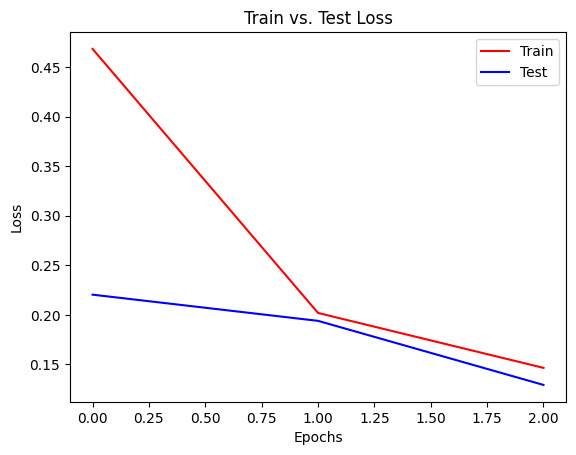

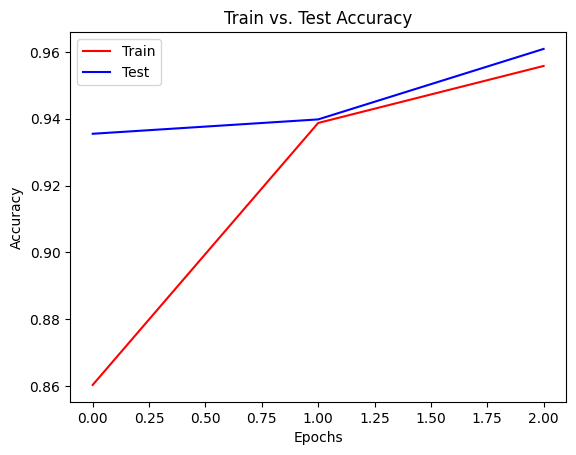

In [ ]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

## **3.6 Comparing the results of the initial settings with the results of the combined adjusted weights:**

### 3.6.1 Initial settings overviw

parameters in initial settings:
- learning rate = 0.001
- batch size = 32
- number of layers = 2
- number of units in layers: 256
- momentum = 0.0

accuracy initial settings:
- epoch 0: 0.8588
- epoch 1: 0.8885
- epoch 2: 0.8991

### 3.6.2 Adjusted settings overview

parameters in adjusted settings:
- learning rate = 0.005
- batch size = 16
- number of layers = 5
- number of units in layers: 256
- momentum = 0.01

accuracy adjusted settings:
- epoch 0: 0.9355
- epoch 1: 0.9398
- epoch 2: 0.9609

With just 3 epochs we were able to imporve the accuracy significantly without taking too much risk in overfitting.